In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from math import floor
import leidenalg as la
import igraph as ig
from elephant.spike_train_generation import homogeneous_poisson_process
import elephant.conversion as conv
import neo as n
import quantities as pq
from quantities import Hz, s, ms

In [2]:
class temporal_network:#object for creating node-aligned(every node exists every layer)
                       #with diagonal coupling(inter-layer edges exist only between node to itself)
        
    ##################################
    # TODO: extend omega(scalar) for vector and matrix
    ##################################
        
    def __init__(self, size, length, window_size, data, **kwargs):
        
        if length < 1: raise ValueError('Object should be a multilayer network with at least 2 layers')
        if size < 3: raise ValueError('Layers must have at least 3 nodes')
        
        self.size = size # number of nodes in every layer
        self.length = length # number of layers
        self.nodes = [i for i in range(self.size)]
        self.windowsize = window_size
        
        #### data: supra__adjacency, list_adjacency, edge_list
        
        ##         if supra__adjacency: creates the list adjacency matrix
        ##
        ##                     --- additional arguments ---
        ##                       - supra_adjacency: supra adjacency matrix of shape (size*time x size*time)
        
        
        ##
        ##         if edge__list: creates directed weighted multilayer network from the egde quadraplets
        ##                      given of the form (i,j,w,t). supra_adjacency and list_adjacency matrices 
        ##                      are automatically created. Caveat: if you use edge_list only firing neurons are going
        ##                      to be taken ito consideration.
        ##
        ##                     --- additional arguments ---
        ##                       - edge_list: list of quadreplets e.g. [(0,2,w1,1),(2,1,w2,1),(0,1,w3,2),(0,2,w4,2)]
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind: if ordinal, only adjacent layers gets connected with strength scalar 'omega'
        ##                               if cardinal, all layers get connected w/ each other w/ strength scalar 'omega'
        
        
        ##         if list__adjacency: creates the supra adjacency matrix from given list of adjacency matrices
        ##                             of monolayer networks
        ##                             TODO:add a warning to check if the adjacency matrices are node-aligned
        ##                      
        ##              
        ##                     --- additional arguments ---
        ##                       - list_adjacency: list of length 'length' that contains individual adjacency
        ##                                         matrices of each layer that are numpy arrays
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind : if ordinal, only adjacent layers gets connected w/ strength scalar'omega'
        ##                                if cardinal, all layers get connected w/ each other w/ strength scalar'omega'
        ##
        ####
                    
        if  data == 'supra__adjacency':
            self.supra_adjacency = kwargs['supra_adjacency']
            list_adjacency = [ [] for i in range(length) ]
            
            for i in range(self.length):
                list_adjacency[i] = self.supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size]
            
            self.list_adjacency = list_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
                
        
        elif data == 'edge__list':
            self.edgelist = kwargs['edge_list']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            list_adjacency = [ [] for i in range(self.length) ]
            for q in range(self.length):
                list_adjacency[q]=np.zeros((self.size,self.size))
            
            for k,e in enumerate(self.edgelist):
                i,j,w,t = e[0], e[1], e[2],e[3]
                supra_adjacency[self.size*(t)+i][self.size*(t)+j] = w
                list_adjacency[t][i][j] = w

        
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            self.list_adjacency = list_adjacency
            
        elif data == 'list__adjacency':
            self.list_adjacency = kwargs['list_adjacency']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            
            for i in range(self.length):
                supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size] = self.list_adjacency[i]
            
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
            
    def aggragate(self, normalized = True):
        t = self.length
        n = self.size
        aggragated = np.zeros((n,n))
        
        for i,c in enumerate(self.list_adjacency):
            aggragated = aggragated + c
            
        if normalized: return (aggragated/t)
        else: return (aggragated)
            
    def modularity_matrix(self, omega, gamma):##TODO: fix modularity matrix
        N = self.size
        T = self.length
        B = np.zeros((N*T,N*T))
        two_mu = 0
        for i in range(T):
            k = np.sum(self.multi_array[i],0)
            two_m = np.sum(k,0)
            two_mu = two_mu + two_m
            B[i*N:(i+1)*N,i*N:(i+1)*N] = self.multi_array[i] - (gamma * k.T*k)/(two_m)
        two_mu = two_mu + 2*omega*N*(T-1)
        
        for p in range(N*(T-1)):
            B[p][p+N] = omega 
            B[p+N][p] = omega
            
        return(B)
    
    def binarize(self, array):
        n,t = array.shape
        binary_spikes = np.zeros(array.shape)
        for i in range(n):
            for j in range(t):
                if array[i][j] == 0: pass
                else: binary_spikes[i][j] = 1
        return(binary_spikes)
    
    def bin_time_series(self, array, gaussian = True, **kwargs):
        #input: nxt matrix 
        #returns: binned time series i.e. l x n x binsize
        
        binsize = self.windowsize
        n = array.shape[0] # number of neurons
        totalsize = array.shape[1] # total duration of spikes
        gauss_array = np.zeros((n,totalsize))
        l = int(totalsize/binsize) # number of resulting layers
        
        if gaussian:
            for i in range(n):
                gauss_array[i] = gaussian_filter(array[i],kwargs['sigma'])
        else: gauss_array= array
            
        A = np.zeros((l,n,binsize))
        for i in range(l):
            A[i] = gauss_array[:,i*binsize:(i+1)*binsize]
        return(A)
    
    def edgelist2edges(self):# helper to create igraphs
        T = self.length
        all_edges = [[] for i in range(T)]
        all_weights = [[] for i in range(T)]
        dtype = [('row',int),('column',int),('weight',float),('layer',int)]
        for k,e in enumerate(np.sort(np.array(self.edgelist, dtype=dtype),order='layer')):
            i,j,w,t = e[0], e[1], e[2],e[3]
            pair = (i,j)
            all_edges[t].append(pair)
            all_weights[t].append(w)
        return (all_edges, all_weights)
    
    def neighbors(self, node_id, layer):
        
        if node_id > self.size: return('Invalid node ID')
        if layer > self.length: return('Invalid layer')
        neighbors = []
        
        for k,e in enumerate(self.edgelist):
            i,j,w,t = e[0],e[1],e[2],e[3]
            if t != layer:pass
            else:
                if i != node_id:pass
                else:neighbors.append(j)
                    
        return(neighbors)
    
    def average_degree(self,layer):
        
        average_degree = 0
        
        for i in range(self.size):
            average_degree = average_degree + len(self.neighbors(i,layer))
        
        return(average_degree/(2*self.size))
    
    def create_igraph(self):
        T = self.length
        N = self.size
        G = []
        edges = self.edgelist2edges()[0]
        weights = self.edgelist2edges()[1]
        for i in range(T):
            G.append(ig.Graph())
            G[i].add_vertices(N)
            G[i].add_edges(edges[i])
            G[i].es['weight'] = weights[i]
            G[i].vs['id'] = list(range(N))
            G[i].vs['node_size'] = 0
        return(G)

    
    def leiden(self, G, interslice, resolution):
        
        layers, interslice_layer, G_full = la.time_slices_to_layers(G, interslice_weight = interslice)
        
        partitions = [la.RBConfigurationVertexPartition(H, 
                                            weights = 'weight', 
                                            resolution_parameter = resolution) for H in layers]
        
        interslice_partition = la.RBConfigurationVertexPartition(interslice_layer, 
                                                                 weights = 'weight',
                                                                 resolution_parameter = 0)
                                                     
        optimiser = la.Optimiser()
        
        diff = optimiser.optimise_partition_multiplex(partitions + [interslice_partition])

        return(partitions, interslice_partition)
    
    def membership(self, interslice_partition): ## returns the community assignments from the leiden algorithm as
        ##                                       tuple (n,t) n is the node id t is the layer that node is in
        n = self.size
        membership = [[] for i in range(interslice_partition._len)]
        for i,m in enumerate(interslice_partition._membership):
            time = floor(i/n)
            node_id = i%n
            membership[m].append((node_id,time))
        return(membership, len(membership))
    
    def community(self, membership, ax):
        n = self.size
        t = self.length
        number_of_colors = len(membership)


        comms = np.zeros((n,t))

        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

        for i, l in enumerate(membership):
            for j,k in enumerate(l):
                comms[k[0]][k[1]] = i

        cmap = mpl.colors.ListedColormap(color)

        #fig,ax = plt.subplots(1,1,figsize=(7,5))
        ax.imshow(comms, interpolation = 'none', cmap = cmap, aspect = 'auto', origin = 'lower', extent = [-0.5,t-0.5,-0.5,n-0.5])
        ax.set_xticks([i for i in range(t)])
        ax.set_yticks([i*10 for i in range(int(n/10)+1)])
        ax.tick_params(axis = 'both', labelsize = 25)
        ax.set_xlabel('Layers (Time)', fontsize = 28)
        ax.set_ylabel('Neuron ID', fontsize = 28)
        ax.set_title('Community Assignments with %d Communities' %len(color), fontsize = 20)
        return(comms, color)
    
    def raster_plot(self, spikes, ax, color = None, **kwargs):#plots the raster plot of the spike activity on a 
        # given axis 'comm_assignment' and 'color' arguments are the outputs of the function 'community' 
        # and they display the community assignment of the spiking activity if provided. if not, raster 
        # ais going to be plotted blue
        binsize = self.windowsize
        binarized_spikes = self.binarize(spikes)
        binned_spikes = self.bin_time_series(binarized_spikes, gaussian = False)
        l,n,t = binned_spikes.shape
                    
        sp = np.nonzero(binned_spikes)
        
        if color is None: 
            col = [0]*l
            clr = [col for i in range(n)]
            color = ['#0000ff']
        else: clr = kwargs['comm_assignment']
        
        cmap = mpl.colors.ListedColormap(color)
        
        for i in range(len(sp[0])):
            ax.scatter(sp[0][i]*binsize+sp[2][i],  sp[1][i], 
                       s = 5, 
                       c = color[int(clr[sp[1][i]][sp[0][i]])], 
                       marker = 'x', 
                       figure = fig, 
                       cmap = cmap)
            
        ax.set_title('Raster Plot', fontsize = 20)
        ax.set_xlabel('Time (Frames)', fontsize = 25)
        ax.set_ylabel('Neuron ID', fontsize = 28)
        ax.set_xticks([t*i for i in range(l+1)])
        ax.set_yticks([5*i for i in range(int(n/5)+1)]+[n])
        ax.tick_params(axis = 'x', labelsize = 13)
        ax.tick_params(axis = 'y', labelsize = 18)
    
    def trajectories(self, thresh = 0.9, node_id = None, community = None, edge_color = True, pv = None):
        #function graphing the edge trajcetories of the temporal
        ## network. Tresh is for thresholding the paths that are strongere than the given value.
        ## if node_id is None, function is going to graph all of the nodes's trajectories.
        ## community argument is for indicating the community assignment
        ## of the nodes if exists, if not pass along None.
        ## edge_color
        ## pv == pass a list of pv cell indices or None --dashes the pv cells
        
        layers = []

        if edge_color == True: ed_color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(self.length)]
        else: e_color = 'black' #["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(self.length)]

            
        if community is None: node_color = 'r'     
        else:
            colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(int(np.max(community)))]
            comap = mpl.colors.ListedColormap(colors)
            node_color = community
            norm = plt.Normalize(0,int(np.max(community)))

        if node_id == None:
            for k in self.nodes:
                for j in range(1,self.length):
                    for i in self.neighbors(k, j):
                        if self.list_adjacency[j][k][i] > thresh:
                            layers.append((j-1, j))
                            layers.append((k, i))
                            try: layers.append('%s' %ed_color[j])
                            except: layers.append('%s'%e_color)
                            
            fig,ax = plt.subplots(1,1,figsize = (20,10))
            plt.plot(*layers,figure = fig)
            plt.title('Temporal trajectories of all the cells that are stronger than %f'%(thresh), fontsize = 20)
            plt.xlabel('Layers',fontsize = 15)
            plt.ylabel('Nodes',fontsize = 15)


            for i in range(self.size):
                x = np.linspace(0, self.length -1, self.length)
                y = np.linspace(i,i, self.length)
                try:plt.scatter(x, y, s = 15, c = node_color, figure = fig, alpha = 1)
                except: plt.scatter(x, y, s = 15, c = node_color[i], norm = norm, figure = fig, alpha = 1, cmap = comap)


        else:
            for j in range(1,self.length):
                for i in self.neighbors(node_id,j):
                    if self.list_adjacency[j][node_id][i] > thresh:
                        layers.append((j-1, j))
                        layers.append((node_id, i))
                        try: layers.append('%s' %ed_color[j])
                        except: layers.append('%s'%e_color)
                            
            fig,ax = plt.subplots(1, 1, figsize = (20,10))
            plt.plot(*layers, figure = fig)
            plt.title('Temporal trajectories of the cell %d that are stronger than %f'%(node_id,thresh), fontsize = 20)
            plt.xlabel('Layers', fontsize = 15)
            plt.ylabel('Nodes', fontsize = 15)
            
            for i in range(self.size):
                x = np.linspace(0, self.length-1, self.length)
                y = np.linspace(i, i, self.length)
                try:plt.scatter(x, y, s = 15, c = node_color, figure = fig, alpha = 1)
                except: plt.scatter(x, y, s = 15, c = node_color[i], norm = norm, figure = fig, alpha = 1, cmap = comap)
        
        if community is not None:
            cbar = plt.colorbar(cmap = cmap)
        
            cbar.set_ticks([i for i in np.arange(0,int(np.max(community)),3)])
            cbar.set_ticklabels([i for i in np.arange(0,int(np.max(community)),3)])
            cbar.set_label('Colorbar for node communities - total of %d communities'%int(np.max(community)), rotation = 270)
        if pv is not None:
            plt.hlines(pv, 0, self.length-1, color = 'b', alpha = 0.4, linestyle = 'dashed')
            plt.yticks(pv, color = 'b')
        plt.tight_layout()
        
        
    def update_interlayer(self, spikes, X, omega_global, percentage, method):
        
        binned_spikes = self.bin_time_series(spikes, gaussian = False)
        sp = np.nonzero(binned_spikes)
        
        layers ,num_neurons, t = self.length, self.size, self.windowsize
        
        count_spikes = np.zeros((layers, num_neurons))
        interlayer = np.ones((layers-1, num_neurons))
    
        if method == 'local':
            for i in range(len(sp[0])):
                l, n, t = sp[0][i], sp[1][i], sp[2][i]
                count_spikes[l][n] = count_spikes[l][n] + 1
            interlayers = []
            for i in range(layers-1):
                zscores = zscore(np.diff(count_spikes, axis = 0)[i])
                layerweights = []
                for j in range(num_neurons):
                    if zscores[j] <= X: layerweights.append(percentage*omega_global)
                    else: layerweights.append(omega_global)
                interlayers.append(layerweights)

        elif method == 'global':
            for i in range(len(sp[0])):
                l, n, t = sp[0][i], sp[1][i], sp[2][i]
                count_spikes[l][n] = count_spikes[l][n] + 1
            interlayers = []
            zscores = zscore(sum(np.diff(count_spikes, axis = 0)))
            for i in range(layers-1):
                layerweights = []
                for j in range(num_neurons):
                    if zscores[j] <= X: layerweights.append(percentage*omega_global)
                    else: layerweights.append(omega_global)
                interlayers.append(layerweights)
    
        #TODO:::  elif method == 'adjacent':
    
        return(interlayers)
    
    def community_consensus_iterative(self, C):
        ## function finding the consensus of a given set of partitions. refer to the paper:
        ## 'Robust detection of dynamic community structure in networks', Danielle S. Bassett, 
        ## Mason A. Porter, Nicholas F. Wymbs, Scott T. Grafton, Jean M. Carlson et al.
        
        
        npart,m  = C.shape 
        C_rand3 = np.zeros((C.shape)) #permuted version of C
        X = np.zeros((m,m)) #Nodal association matrix for C
        X_rand3 = X # Random nodal association matrix for C_rand3

        # randomly permute rows of C
        for i in range(npart):
            C_rand3[i,:] = C[i,np.random.permutation(m)]
            for k in range(m):
                for p in range(m):
                    if int(C[i,k]) == int(C[i,p]): X[p,k] = X[p,k] + 1 #(i,j) is the # of times node i and j are assigned in the same comm
                    if int(C_rand3[i,k]) == int(C_rand3[i,p]): X_rand3[p,k] = X_rand3[p,k] + 1 #(i,j) is the # of times node i and j are expected to be assigned in the same comm by chance
        #thresholding
        #keep only associated assignments that occur more often than expected in the random data

        X_new3 = np.zeros((m,m))
        X_new3[X>(np.max(np.triu(X_rand3,1)))/2] = X[X>(np.max(np.triu(X_rand3,1)))/2]
        
        ##turn thresholded nodal association matrix into igraph
        edge_list = []
        weight_list = []
        for k,e in enumerate(np.transpose(np.nonzero(X_new3))):
            i,j = e[0], e[1]
            pair = (i,j)
            edge_list.append(pair)
            weight_list.append(X_new3[i][j])
        
        G = ig.Graph()
        G.add_vertices(m)
        G.add_edges(edge_list)
        G.es['weight'] = weight_list
        G.vs['id'] = list(range(m))
        
        optimiser = la.Optimiser()
        partition = la.ModularityVertexPartition(G, weights = 'weight')
        diff = optimiser.optimise_partition(partition, n_iterations = -1)
        
        return(partition)
    
    def run_community_detection(self, interlayers, resolutions, update = False, consensus = False, **kwargs):
        
        grid = len(interlayers)
        membership_partitions = {}
        parameter_plane = np.zeros((len(resolutions),len(interlayers)))
        C = np.zeros((grid*grid, self.size*self.length))
        for i,e in enumerate(interlayers):
            membership_labels = []
            igraphs = self.create_igraph()
    
            ##update interlayer edges
            if update: inter_edge = self.update_interlayer(kwargs['spikes'], X = 0.5, omega_global = e, percentage = 0.01, method = kwargs['method'])    
            else: inter_edge = e
                
            for j,f in enumerate(resolutions):
                parts, inter_parts = self.leiden(igraphs, inter_edge, f)
                C[i*grid+j,:] = inter_parts.membership
                comm_labels, comm_size  = self.membership(inter_parts)
                membership_labels.append(comm_labels)
                parameter_plane[i][j] = comm_size
            membership_partitions['interlayer %.2f'%e] = membership_labels
            
        if consensus: return(membership_partitions, self.membership(self.community_consensus_iterative(C)))
        else: return(membership_partitions, parameter_plane)

In [3]:
def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation= normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    return(X_full, X, lag)

In [4]:
def bin_time_series(array, binsize, gaussian = True, **kwargs):
        #input: nxt matrix 
        #returns: binned time series i.e. l x n x binsize
        
    n = array.shape[0] # number of neurons
    totalsize = array.shape[1] # total duration of spikes
    gauss_array = np.zeros((n,totalsize))
    l = int(totalsize/binsize) # number of resulting layers
        
    if gaussian:
        for i in range(n):
            gauss_array[i] = gaussian_filter(array[i],kwargs['sigma'])
    else: gauss_array= array
            
    A = np.zeros((l,n,binsize))
    for i in range(l):
        A[i] = gauss_array[:,i*binsize:(i+1)*binsize]
    return(A)

def binarize(array):
    n,t = array.shape
    binary_spikes = np.zeros((n,t))
    for i in range(n):
        for j in range(t):
            if array[i][j] == 0: pass
            else: binary_spikes[i][j] = 1
    return(binary_spikes)

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

def jitter(spike, k):
    #jittering the given spike train
    jittered = np.zeros(spike.shape)
    for i in np.nonzero(spike)[1]:
        jitt = random.randint(-k,k)
        try:jittered[0,i+jitt] = 1
        except:jittered[0,i] = 1
    return(jittered)

def spike_count(spikes, num_bins,  t_min = None, t_max = None):
    n,t = spikes.shape
    if t_min is None: t_min = 0
    if t_max is None: t_max = t
    if t_max<=t_min: raise ValueError('t_min should be less than t_max')
    spike_count = []
    fig, ax = plt.subplots(1,1, figsize = (10,10))
    for i in range(n):
        spike_count.append(np.sum(spikes[i][t_min:t_max]))
    n, bins, patches = ax.hist(spike_count, num_bins, color = 'blue')
    ax.set_title("Spike Rate Distribution")
    ax.set_xlabel("Total Number of Spikes")
    ax.set_ylabel("Number of Neurons")
    return(n,bins)

In [5]:
num_comms = 1 # number ofcommunities to expand
spike_rate = 10 # spike rate per commiunity
comm_size = [20,20,20,20,20]
num_neurons = int(sum(comm_size))
bin_size = 1000.0 # in frames, in every bin_size, a community activity occurs
seconds = len(comm_size)
total_duration = int(seconds*bin_size)
window_size = 1000 # size, in frames, each adjacency matrix correspond to. better to be equal to bin_size 
standard_dev = 1.2 # for gaussian kernel
k = 5 #for jittering the spikes
layers = int(total_duration/window_size)

In [6]:
spikes = np.zeros((num_neurons,total_duration))
master_spike = np.zeros((1,total_duration))
master = homogeneous_poisson_process(rate = spike_rate*Hz, t_start = 0.0*ms, t_stop = total_duration*ms, as_array=True) 

for i,e in enumerate(master):    
    master_spike[0][int(e)] = 1
for i in range(comm_size[0]):
    spikes[i] = jitter(master_spike, 5)

comms = []
for i in range(1,len(comm_size)):
    comms.append([homogeneous_poisson_process(rate = spike_rate*Hz, t_start = 0.0*ms, t_stop = i*bin_size*ms, as_array=True) for j in range(comm_size[i])])

neuron_count = comm_size[0]
for i,e in enumerate(comms):## this is for 
    for j,f in enumerate(e):
        for k,m in enumerate(f):
            spikes[neuron_count+j][int(m)] = 1
    neuron_count = neuron_count + len(e)
            
neuron_count = comm_size[0]
for i in range(1,len(comms)+1):
    for j in range(neuron_count,neuron_count+comm_size[i]):
        for k in np.nonzero(spikes[0][(i*1000):])[0]:
            jitt = random.randint(-5,5)
            try:spikes[j,(i*1000)+k+jitt] = 1
            except:spikes[j,k] = 1
    neuron_count = neuron_count + comm_size[i]

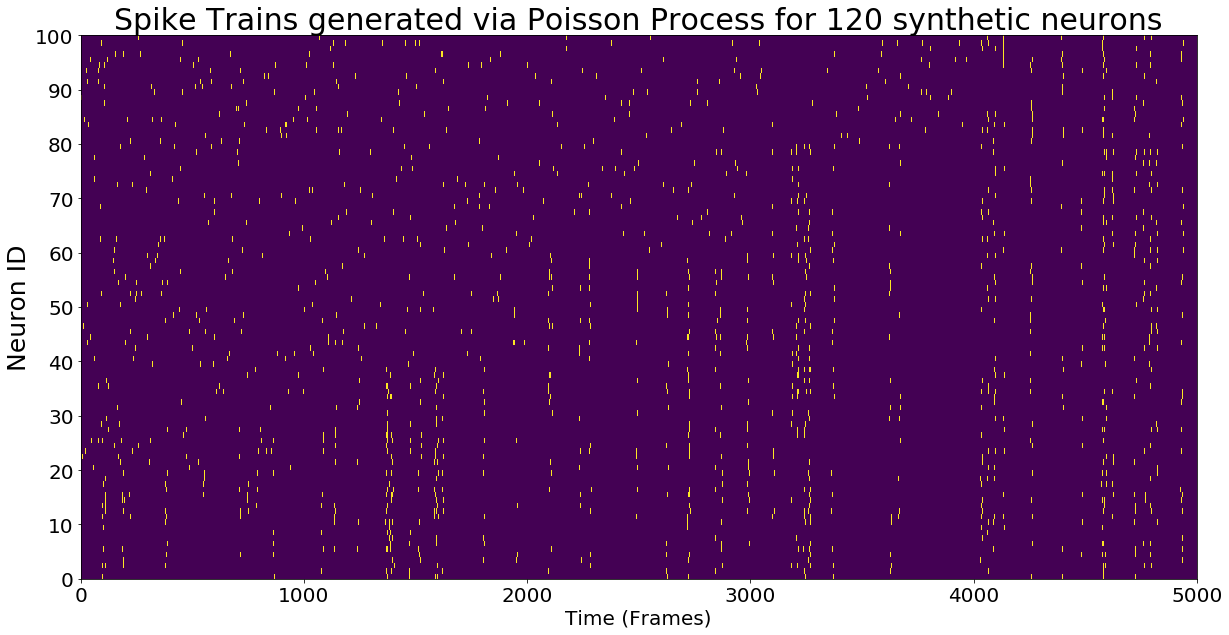

In [7]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.imshow(spikes, origin = 'lower', interpolation='nearest', aspect='auto',  extent = [0,5000,0,100])
ax.set_title('Spike Trains generated via Poisson Process for 120 synthetic neurons', fontsize= 30)
ax.set_xlabel('TIME (in Miliseconds)', fontsize = 20)
ax.set_xticks([j*1000 for j in range(6)])
ax.set_yticks([i*10 for i in range(11)])
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.set_xlabel('Time (Frames)', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results_consensus/spiketrain_vary_X_rho.pdf')

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  4.,
         0.,  2.,  0.,  3.,  0.,  3.,  0.,  8.,  0.,  3.,  0.,  4.,  7.,
         0.,  4.,  0.,  7.,  0., 10.,  0.,  5.,  0.,  5.,  0., 10.,  8.,
         0., 10.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  2.]),
 array([42.  , 42.54, 43.08, 43.62, 44.16, 44.7 , 45.24, 45.78, 46.32,
        46.86, 47.4 , 47.94, 48.48, 49.02, 49.56, 50.1 , 50.64, 51.18,
        51.72, 52.26, 52.8 , 53.34, 53.88, 54.42, 54.96, 55.5 , 56.04,
        56.58, 57.12, 57.66, 58.2 , 58.74, 59.28, 59.82, 60.36, 60.9 ,
        61.44, 61.98, 62.52, 63.06, 63.6 , 64.14, 64.68, 65.22, 65.76,
        66.3 , 66.84, 67.38, 67.92, 68.46, 69.  ]))

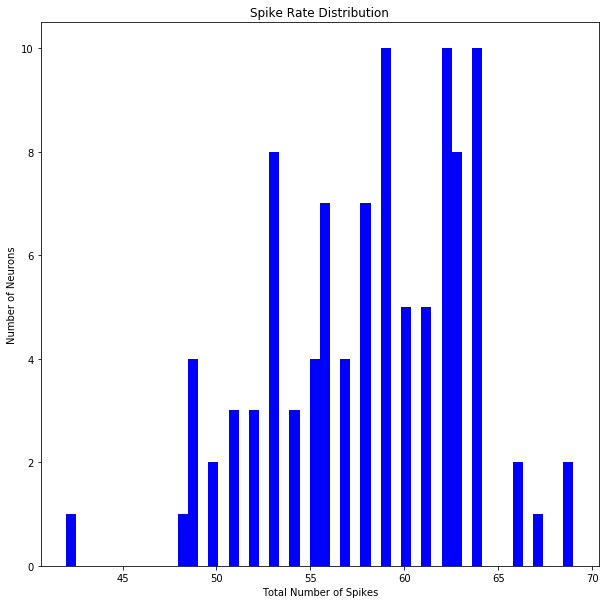

In [8]:
spike_count(spikes, 50)
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results_consensus/spike_distribution_vary_X_rho.pdf')

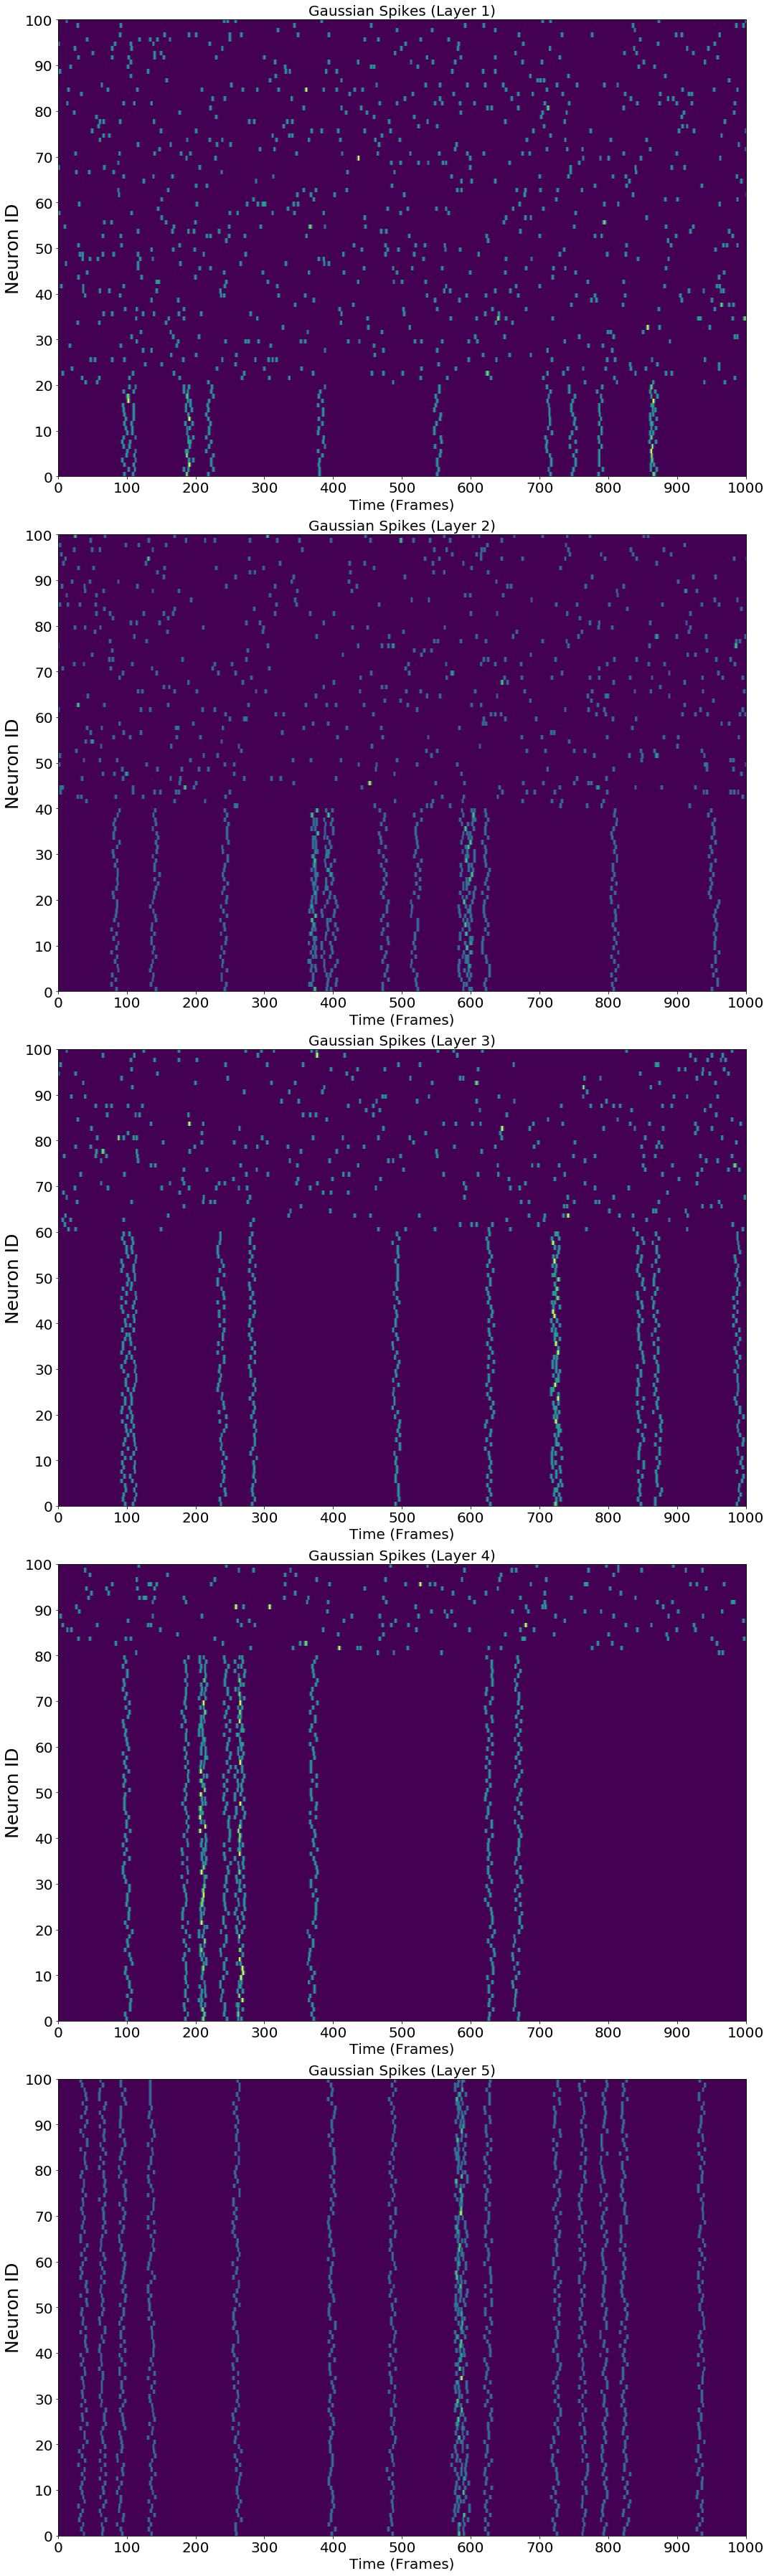

In [9]:
binned_spikes = bin_time_series(spikes, window_size, gaussian = True, sigma = standard_dev)
fig,ax = plt.subplots(layers,1,figsize=(15,50))
for i in range(layers):
    ax[i].imshow(binned_spikes[i], origin = 'lower', interpolation='nearest', aspect='auto', extent = [0,1000,0,100])
    ax[i].set_title('Gaussian Spikes (Layer %d)'%(i+1), fontsize = 20)
    ax[i].set_xlabel('TIME (in Miliseconds)', fontsize = 20)
    ax[i].set_xticks([j*100 for j in range(11)])
    ax[i].set_yticks([j*10 for j in range(11)])
    ax[i].set_ylabel('Neuron ID', fontsize = 25)
    ax[i].set_xlabel('Time (Frames)', fontsize = 20)
    ax[i].tick_params(axis = 'both', labelsize = 20)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results_consensus/binned_spiketrain_vary_X_rho.pdf')

In [10]:
##create cross-correlation matrices that are the adjacency matrices of the network at each layer
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


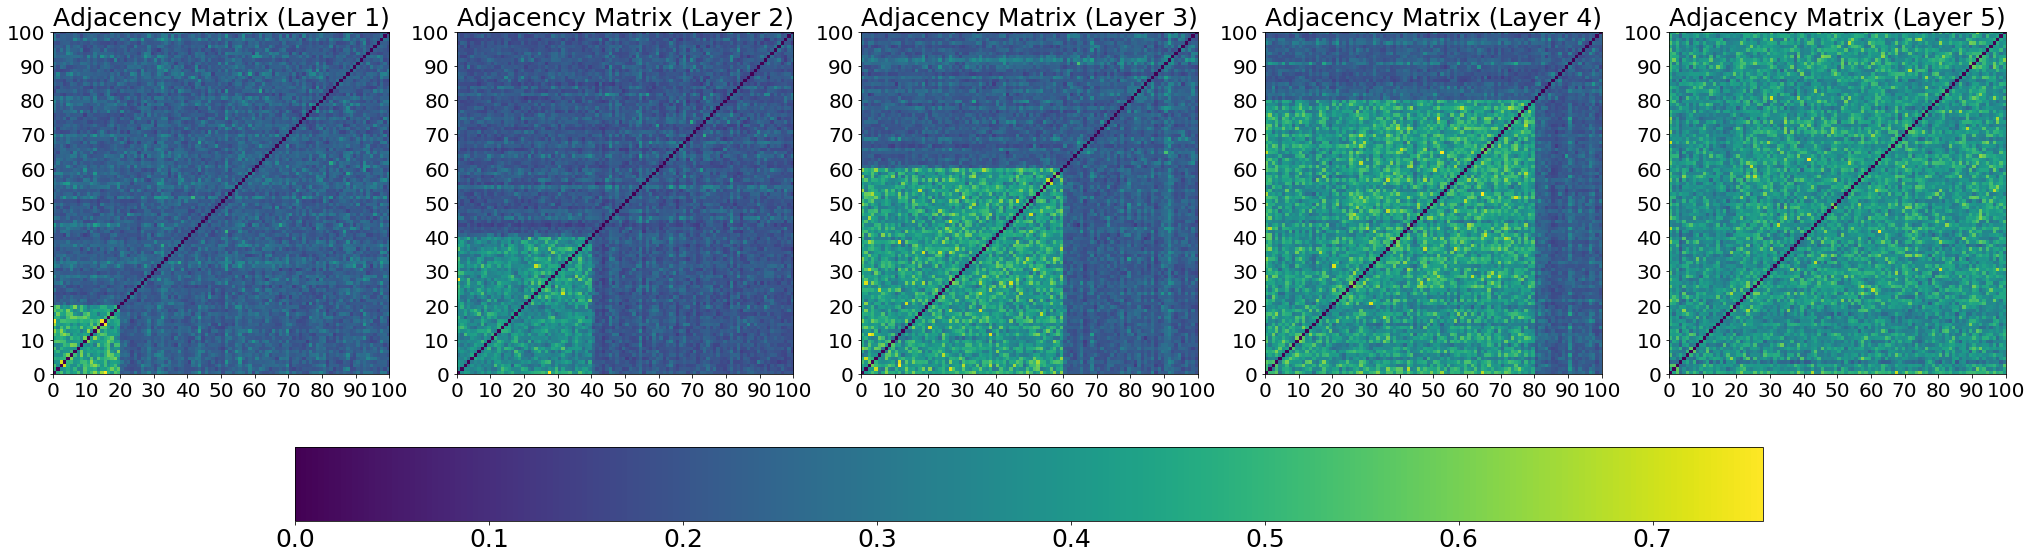

In [11]:
fig,ax = plt.subplots(1, 5, figsize = (35,9))
for i in range(5):
    k = ax[i].imshow(adjacency_matrices[i], 
                            origin = 'lower', 
                            interpolation='nearest', 
                            aspect='auto',  
                            extent = [0, num_neurons, 0, num_neurons])
    ax[i].set_title('Adjacency Matrix (Layer %d)'%(i+1), fontsize = 25)
    ax[i].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
    ax[i].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
    ax[i].tick_params(axis = 'both', labelsize = 20)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25) 
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results_consensus/adjacency_vary_X_rho.pdf')

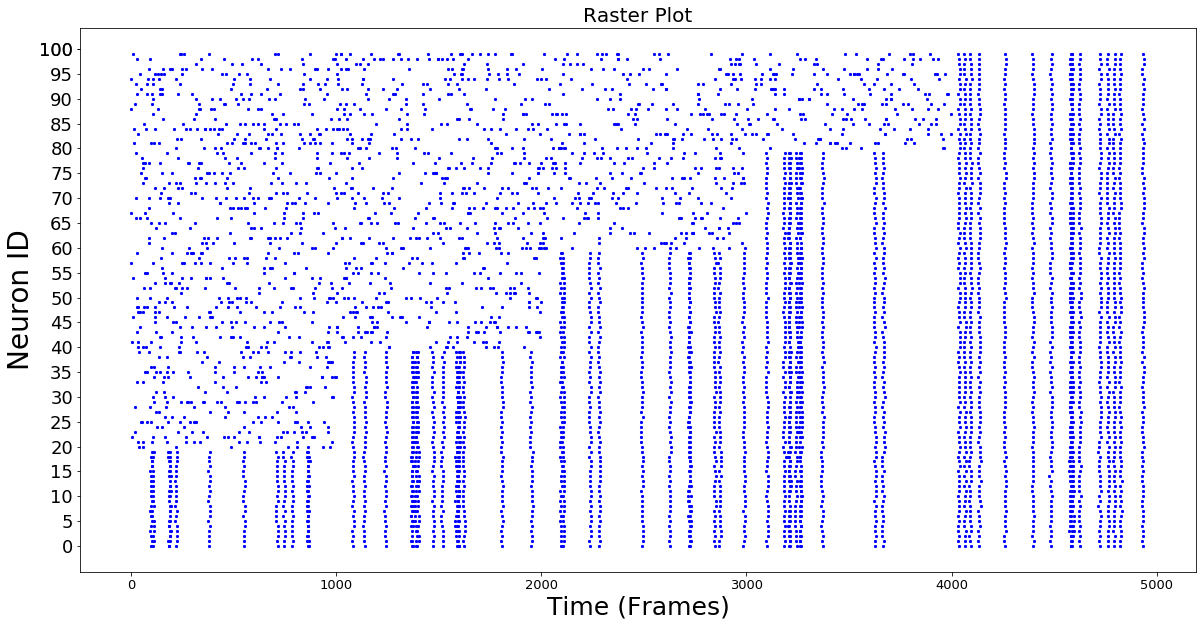

In [12]:
TN = temporal_network(num_neurons, 
                      layers, 
                      window_size, 
                      data = 'list__adjacency', 
                      list_adjacency = adjacency_matrices, 
                      omega = 1, 
                      kind = 'ordinal')

fig,ax = plt.subplots(1,1, figsize = (20,10))
TN.raster_plot(spikes, ax)
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results_consensus/raster_plot_vary_X_rho.pdf')

In [14]:
grid = 30
index = 10

x_standardevs = np.linspace(-2,2,9)
ro = [0.1, 0.01]

resolutions = np.linspace(0.8, 1, grid)
interlayers = np.linspace(0.2, 0.8, grid)

In [ ]:
membership_partitions_noupdate, consensus_partition_noupdate = TN.run_community_detection(interlayers, 
                                                                         resolutions, 
                                                                         consensus = True)

In [ ]:
fig,ax = plt.subplots(9,3,figsize = (50,150))
for i, x_standardev in enumerate(x_standardevs):
    membership_partitions_localupdate, consensus_partition_localupdate = TN.run_community_detection(interlayers, 
                                                                                                resolutions, 
                                                                                                update = True,
                                                                                                consensus = True,
                                                                                                spikes = spikes, 
                                                                                                X = x_standardev, 
                                                                                                percentage = ro[0], 
                                                                                                method = 'local')
    
    membership_partitions_globalupdate, consensus_partition_globalupdate = TN.run_community_detection(interlayers, 
                                                                                                  resolutions, 
                                                                                                  update = True,
                                                                                                  consensus = True,
                                                                                                  spikes = spikes, 
                                                                                                  X = x_standardev, 
                                                                                                  percentage = ro[0], 
                                                                                                  method = 'global')
    
    comms_noupdate, c_noupdate = TN.community(consensus_partition_noupdate[0], ax[i][0])
    comms_localupdate, c_localupdate = TN.community(consensus_partition_localupdate[0], ax[i][1])
    comms_globalupdate, c_globalupdate = TN.community(consensus_partition_globalupdate[0], ax[i][2])
    
    ax[i][0].set_title('%d Comms, Consensus, No Updates'%len(c_noupdate), fontsize = 32)
    ax[i][1].set_title('%d Comms, Consensus, Local Updates, X=%.2f, rho=%.2f'%(len(c_localupdate), x_standardev, ro[0]), fontsize = 32)
    ax[i][2].set_title('%d Comms, Consensus, Global Updates, X=%.2f, rho=%.2f'%(len(c_globalupdate), x_standardev, ro[0]), fontsize = 32)
    
plt.tight_layout()

plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results_consensus/consensus_vary_X_rho_0.pdf')

In [ ]:
fig,ax = plt.subplots(9,3,figsize = (50,150))
for i, x_standardev in enumerate(x_standardevs):
    membership_partitions_localupdate, consensus_partition_localupdate = TN.run_community_detection(interlayers, 
                                                                                                resolutions, 
                                                                                                update = True,
                                                                                                consensus = True,
                                                                                                spikes = spikes, 
                                                                                                X = x_standardev, 
                                                                                                percentage = ro[1], 
                                                                                                method = 'local')
    
    membership_partitions_globalupdate, consensus_partition_globalupdate = TN.run_community_detection(interlayers, 
                                                                                                  resolutions, 
                                                                                                  update = True,
                                                                                                  consensus = True,
                                                                                                  spikes = spikes, 
                                                                                                  X = x_standardev, 
                                                                                                  percentage = ro[1], 
                                                                                                  method = 'global')
    
    comms_noupdate, c_noupdate = TN.community(consensus_partition_noupdate[0], ax[i][0])
    comms_localupdate, c_localupdate = TN.community(consensus_partition_localupdate[0], ax[i][1])
    comms_globalupdate, c_globalupdate = TN.community(consensus_partition_globalupdate[0], ax[i][2])
    
    ax[i][0].set_title('%d Comms, Consensus, No Updates'%len(c_noupdate), fontsize = 32)
    ax[i][1].set_title('%d Comms, Consensus, Local Updates, X=%.2f, rho=%.2f'%(len(c_localupdate), x_standardev, ro[1]), fontsize = 32)
    ax[i][2].set_title('%d Comms, Consensus, Global Updates, X=%.2f, rho=%.2f'%(len(c_globalupdate), x_standardev, ro[1]), fontsize = 32)
    
plt.tight_layout()

plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results_consensus/consensus_vary_X_rho_1.pdf')